<a href="https://colab.research.google.com/github/86lekwenshiung/Neural-Network-with-Tensorflow/blob/main/05_Transfer_Learning_with_Tensorflow_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Transfer Learning with Tensorflow Part 2 : Fine Tuning
___

Transfer Learning leverages a working model's exisiting architecture and learned patterns for our own problem.

2 main benefits:
  1. Leverage an existing neural network architecture proven to work on similiar , related problems.
  2. Leverage a working neural network architecture which has already learned patterns on similiar pattern on similiar data to our own , then we can adapt those pattern to our own.

<p align = 'center'>
  <img src = 'https://raw.githubusercontent.com/86lekwenshiung/Neural-Network-with-Tensorflow/main/images/04-transfer-learning-feature-extraction.png'>
</p>

### Import Libraries
___


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import datetime

import os
import zipfile
import pathlib

### Check GPU
___

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### General Functions
___

In [3]:
# Refer to Tensorboard Doc String : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
def create_tensorboard_callback(dir_name , experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """

  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  

  print(f'Saving Tensorboard log files to {log_dir}')

In [38]:
def plot_loss_curves(history):
  loss = history.history['loss']
  accuracy = history.history['accuracy']

  val_loss = history.history['val_loss']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize = (12,8))

  #Plot Accuracy
  plt.subplot(1,2,1)
  plt.plot(epochs , loss , label = 'training loss')
  plt.plot(epochs , val_loss , label = 'validation loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  #Plot Accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs , accuracy , label = 'training accuracy')
  plt.plot(epochs , val_accuracy , label = 'validation accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()


In [5]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(filenames)} files and {len(dirnames)} in {dirpath}')

In [6]:
def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

#1.0 Getting Data from Food101
___

Using pretrained model within tf.keras.application and applt them to our own food images.
Source : https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [7]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

--2021-09-07 03:18:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 64.233.166.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  56.3MB/s    in 2.9s    

2021-09-07 03:18:45 (56.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [8]:
# Unzip Data
unzip_data('10_food_classes_10_percent.zip')

###1.1 Exploring File Path
___

In [9]:
walk_through_dir('10_food_classes_10_percent')

There are 0 files and 2 in 10_food_classes_10_percent
There are 0 files and 10 in 10_food_classes_10_percent/train
There are 75 files and 0 in 10_food_classes_10_percent/train/sushi
There are 75 files and 0 in 10_food_classes_10_percent/train/fried_rice
There are 75 files and 0 in 10_food_classes_10_percent/train/ramen
There are 75 files and 0 in 10_food_classes_10_percent/train/pizza
There are 75 files and 0 in 10_food_classes_10_percent/train/chicken_wings
There are 75 files and 0 in 10_food_classes_10_percent/train/hamburger
There are 75 files and 0 in 10_food_classes_10_percent/train/steak
There are 75 files and 0 in 10_food_classes_10_percent/train/chicken_curry
There are 75 files and 0 in 10_food_classes_10_percent/train/ice_cream
There are 75 files and 0 in 10_food_classes_10_percent/train/grilled_salmon
There are 0 files and 10 in 10_food_classes_10_percent/test
There are 250 files and 0 in 10_food_classes_10_percent/test/sushi
There are 250 files and 0 in 10_food_classes_10_pe

### 1.2 Setting up file path
___

In [10]:
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

### 1.3 Setting up Class Name
___

In [11]:
data_dir = pathlib.Path(train_dir)

for item in data_dir.glob('*'):
  print(item.name)

sushi
fried_rice
ramen
pizza
chicken_wings
hamburger
steak
chicken_curry
ice_cream
grilled_salmon


In [12]:
class_name = [item.name for item in data_dir.glob('*')]
class_name

['sushi',
 'fried_rice',
 'ramen',
 'pizza',
 'chicken_wings',
 'hamburger',
 'steak',
 'chicken_curry',
 'ice_cream',
 'grilled_salmon']

### 1.4 Visualising Data
___

In [13]:
img_size = (224,224)
batch_size = 32

train_data_10_percent = image_dataset_from_directory(directory=train_dir,
                                                     image_size = img_size,
                                                     label_mode = 'categorical',
                                                     batch_size = batch_size)

test_data_10_percent = image_dataset_from_directory(directory = test_dir,
                                                    image_size = img_size,
                                                    label_mode = 'categorical',
                                                    batch_size = batch_size)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [14]:
# Create batches of 32 images of pixel size 224, 244, splitting into red , green , blue color channels
# 2 array of (images , labels)
print(test_data_10_percent)

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>


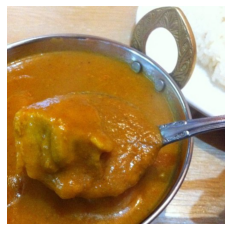

In [15]:
sample_path = '/content/10_food_classes_10_percent/train/chicken_curry/'
random_image = sample_path + '/' + random.choice(os.listdir(sample_path))

img = plt.imread(random_image)
plt.axis(False)
plt.imshow(img);

In [16]:
def view_random_image(target_class , target_path):
  sample_path = target_path + '/' + target_class
  random_image = sample_path + '/' + random.choice(os.listdir(sample_path))

  img = plt.imread(random_image)
  plt.imshow(img)
  plt.axis(False)
  plt.title(f'{target_class} , {img.shape}')


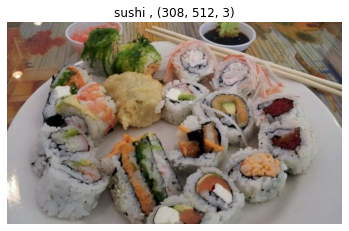

In [17]:
view_random_image(target_class ='sushi',
                  target_path = '/content/10_food_classes_10_percent/train')

#### 1.4.1 Alternative method to get Class Name
___

In [18]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### 2.0 Model 0 :Baseline Model wit Functional API
___

|Experiment|Data|Preprocessing|Model|
|---|---|---|---|
|Model 0|10 classes of Food101 data at 10%| None|Feature Extractor : EfficientNet B0|
|Model 1|10 classes of Food101 data at 1%|Random Flip, Rotation n, Augmentation|EfficientNetB0|
|Model 2|Same as Model 0|Same as Model 1|EfficientNetB0|
|Model 3|Same as Model 0|Same as Model 1| Fine tuning: EfficientNetB0 with top layers trained on custom data , top 10 layers unfrozen|
|Model 4|10 classes of Food101 data at 100%| Same as Model 1|Same as Model 3|

In [28]:
# Create Model 1 with functional API : https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0

# Step 1 
efficientnetb0 = tf.keras.applications.EfficientNetB0(include_top = False)

# Step 2 : Freeze the base model
efficientnetb0.trainable = False

# Step 3 : Create Input Layers
inputs = tf.keras.layers.Input(shape = (224,224,3) , name = 'input_layer')

# Rescaling : EfficientNet has a pre-build pre-scale function

# Step 5: Feed input into model
x = efficientnetb0(inputs)
print(f'Shape of Model {x.shape}')

# # Step 6: Average Pool the model before output
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pool')(x)
print(f'Shape of Model after Passing through Average pool {x.shape}')

# Step 7: Create Output layer
outputs = tf.keras.layers.Dense(10 , activation = 'softmax' , name = 'output_layers')(x)
print(f'Output Shape : {outputs.shape}')

# Step 8: Average Pool the model before output
model_0 = tf.keras.Model(inputs , outputs)

Shape of Model (None, 7, 7, 1280)
Shape of Model after Passing through Average pool (None, 1280)
Output Shape : (None, 10)


In [29]:
# Fitting the Model

model_0.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = 'accuracy')

history_0 = model_0.fit(train_data_10_percent, 
                        epochs = 5,
                        callbacks = create_tensorboard_callback(dir_name = 'save_dir',
                                                                  experiment_name = 'model_0'),
                        validation_data = test_data_10_percent,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_steps = len(test_data_10_percent))

Saving Tensorboard log files to save_dir/model_0/20210907-032809
Epoch 1/5
24/24 [==============================] - 22s 630ms/step - loss: 1.8857 - accuracy: 0.4040 - val_loss: 1.3365 - val_accuracy: 0.6944
Epoch 2/5
24/24 [==============================] - 13s 555ms/step - loss: 1.1327 - accuracy: 0.7373 - val_loss: 0.9229 - val_accuracy: 0.7836
Epoch 3/5
24/24 [==============================] - 13s 558ms/step - loss: 0.8377 - accuracy: 0.7933 - val_loss: 0.7521 - val_accuracy: 0.8172
Epoch 4/5
24/24 [==============================] - 14s 561ms/step - loss: 0.6900 - accuracy: 0.8293 - val_loss: 0.6646 - val_accuracy: 0.8332
Epoch 5/5
24/24 [==============================] - 14s 560ms/step - loss: 0.5878 - accuracy: 0.8493 - val_loss: 0.6100 - val_accuracy: 0.8400


#### 2.0.1 Visualing Model Layers from EfficientNetB0
___

In [25]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 10s 125ms/step - loss: 0.4564 - accuracy: 0.8556


[0.45636186003685, 0.8555999994277954]

In [26]:
for layer_number , layer in enumerate(model_0.layers):
  print(layer_number , layer.name)

0 input_layer
1 efficientnetb0
2 global_average_pool
3 output_layers


In [33]:
model_0.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pool (GlobalA (None, 1280)              0         
_________________________________________________________________
output_layers (Dense)        (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [30]:
for layer_number , layer in enumerate(efficientnetb0.layers):
  print(layer_number , layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [32]:
efficientnetb0.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, None, None, 3 7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_1[0][0]            
_____________________________________________________________________________________

#### 2.0.2 Visualing Loss Curves
___

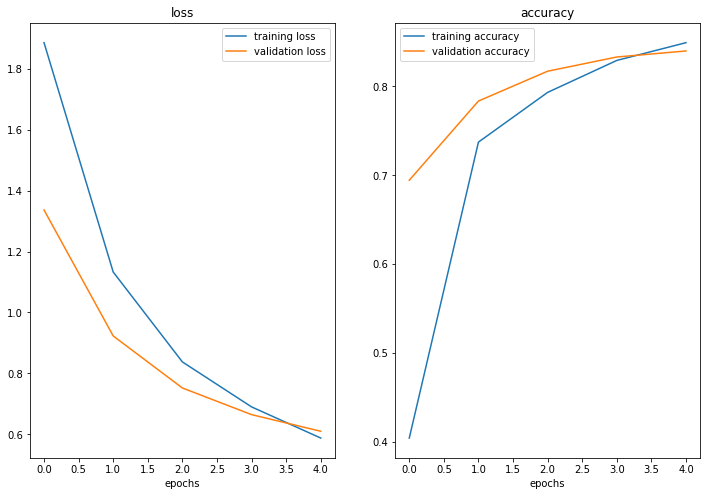

In [39]:
plot_loss_curves(history_0)